# Running spike sorting on Neuropixel probe data

In [1]:
# need library to save as json
import os
import re
import subprocess
from pathlib import Path
import numpy as np
from kilosort.io import save_probe
from kilosort.parameters import DEFAULT_SETTINGS
from kilosort.run_kilosort import run_kilosort
import SGLXMetaToCoords as sglx

### Sorting data from 24-05-31

Files directory: D:\SortingTemp\24-05-31_DH23_A1-IC_g0\24-05-31_DH23_A1-IC_g0_imec0
Meta file: D:\SortingTemp\24-05-31_DH23_A1-IC_g0\24-05-31_DH23_A1-IC_g0_imec0\24-05-31_DH23_A1-IC_g0_t0.imec0.ap.meta
Binary file: D:\SortingTemp\24-05-31_DH23_A1-IC_g0\24-05-31_DH23_A1-IC_g0_imec0\24-05-31_DH23_A1-IC_g0_t0.imec0.ap.bin
Data directory: D:\SortingTemp
Run name: 24-05-31_DH23_A1-IC
Gate number: 0
Trigger number: 0
Probe number: 0


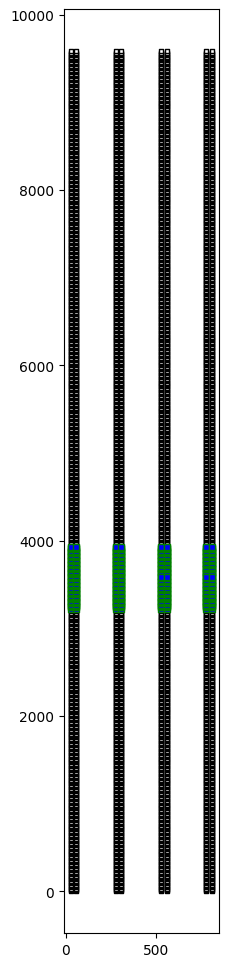

Saving probe file to: D:\SortingTemp\24-05-31_DH23_A1-IC_g0\24-05-31_DH23_A1-IC_g0_imec0\probe.json
Running CatGT...

Interpreting binary file as default dtype='int16'. If data was saved in a different format, specify `data_dtype`.
Using GPU for PyTorch computations. Specify `device` to change this.
Preprocessing filters computed in  73.80s; total  73.86s

computing drift
Re-computing universal templates from data.


c:\Users\dbh60\.conda\envs\kilosort\lib\site-packages\threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
100%|██████████| 13507/13507 [2:26:06<00:00,  1.54it/s]  


drift computed in  9411.45s; total  9485.34s

Extracting spikes using templates
Re-computing universal templates from data.


100%|██████████| 13507/13507 [2:28:53<00:00,  1.51it/s]  


36410702 spikes extracted in  9011.34s; total  18496.78s

First clustering


100%|██████████| 24/24 [1:20:59<00:00, 202.49s/it]


1301 clusters found, in  4874.39s; total  23371.17s

Extracting spikes using cluster waveforms


100%|██████████| 13507/13507 [1:45:19<00:00,  2.14it/s]


58358271 spikes extracted in  6346.31s; total  29717.48s

Final clustering


100%|██████████| 24/24 [9:02:53<00:00, 1357.23s/it]   


819 clusters found, in  32573.84s; total  62291.46s

Merging clusters
736 units found, in  161.53s; total  62452.99s

Saving to phy and computing refractory periods
272 units found with good refractory periods

Total runtime: 62952.72s = 17:29:13 h:m:s


In [3]:
# set your data directory here, should contain the .ap.bin and .ap.meta files
file_dir = Path("D:\\SortingTemp\\24-05-31_DH23_A1-IC_g0\\24-05-31_DH23_A1-IC_g0_imec0")

# skip CatGT if already ran
skip_catgt = True

# useful Kilosort settings
config = {'tmin': 0, # start time in seconds
          'tmax': np.inf, # end time in seconds
          'artifact_threshold': np.inf, # threshold for detecting artifacts
          'batch_size': 60000, # number of samples per batch
          'nblocks': 1, # number of blocks to split the data into for drift correction
          'Th_universal': 9, # threshold for detecting spikes used in universal templates
          'Th_learned': 8} # threshold for detecting spikes used in learned templates

# get the data dir
data_dir = file_dir.parents[1]

# get the meta file in the folder
meta_file = str(list(file_dir.glob('*.ap.meta'))[0])

# get the binary file in the folder
bin_file = list(file_dir.glob('*.ap.bin'))
bin_file = [str(x) for x in bin_file if str(x).find('_tcat') == -1][0]

# get the run name
run_name = file_dir.parts[-2]
run_name = re.sub(r'_g\d+$', '', run_name)

# get the gate and trigger numbers
gate_num = re.search(r'_g(\d+)', bin_file).group(1)
trig_num = re.search(r'_t(\d+)', bin_file).group(1)

# get the probe number
probe_num = re.search(r'_imec(\d+)', bin_file).group(1)

# print directory and file names
print('Files directory: {}'.format(file_dir))
print('Meta file: {}'.format(meta_file))
print('Binary file: {}'.format(bin_file))
print('Data directory: {}'.format(data_dir))
print('Run name: {}'.format(run_name))
print('Gate number: {}'.format(gate_num))
print('Trigger number: {}'.format(trig_num))
print('Probe number: {}'.format(probe_num))

# get the coordinates of the electrodes from the meta file
xc, yc, shanks, kcoords, n_chan = sglx.MetaToCoords(Path(meta_file), outType=0, showPlot=True)
shank_sep = 250
xc = xc + shanks*shank_sep
n_chan = int(n_chan)
chan_map = np.arange(n_chan-1) # exclude last channel which is sync

probe =  {'chanMap': chan_map, 'xc': xc, 'yc': yc, 'kcoords': kcoords, 'n_chan': n_chan}

probe_file = os.path.join(str(file_dir), 'probe.json')
print('Saving probe file to: {}'.format(probe_file))

save_probe(probe, probe_file)

# test if already ran CatGT
tcat_file = bin_file.replace('_t'+trig_num, '_tcat')

if skip_catgt and Path(tcat_file).exists():
    print('CatGT already ran, skipping...')
else:
    print('Running CatGT...')
    # file and directory names for CatGT
    catgt_files = '-dir={} -run={} -g={} -t={} -prb={}'.format(
        data_dir, run_name, gate_num, trig_num, probe_num)

    # options for CatGT, can be edited as needed
    catgt_opts = '-ap -prb_fld -gbldmx' # -apfilter=butter,2,300,9000, dropped filter

    # full command for CatGT
    catgt_cmd = 'CatGT {} {}'.format(catgt_files, catgt_opts)

    # run catGT
    cmd_out = subprocess.run(catgt_cmd, shell=True, capture_output=True)
    print(cmd_out.stdout.decode('utf-8'))

# initialize settings with default values
settings = DEFAULT_SETTINGS

# update settings with custom values from config
for key, value in config.items():
    settings[key] = value

# run Kilosort
ops, st, clu, tf, Wall, similar_templates, is_ref, est_contam_rate, kept_spikes \
    = run_kilosort(settings, probe=probe, filename=tcat_file, data_dir=file_dir)

Files directory: D:\SortingTemp\24-05-31_DH23_A1-IC_g0\24-05-31_DH23_A1-IC_g0_imec1
Meta file: D:\SortingTemp\24-05-31_DH23_A1-IC_g0\24-05-31_DH23_A1-IC_g0_imec1\24-05-31_DH23_A1-IC_g0_t0.imec1.ap.meta
Binary file: D:\SortingTemp\24-05-31_DH23_A1-IC_g0\24-05-31_DH23_A1-IC_g0_imec1\24-05-31_DH23_A1-IC_g0_t0.imec1.ap.bin
Data directory: D:\SortingTemp
Run name: 24-05-31_DH23_A1-IC
Gate number: 0
Trigger number: 0
Probe number: 1


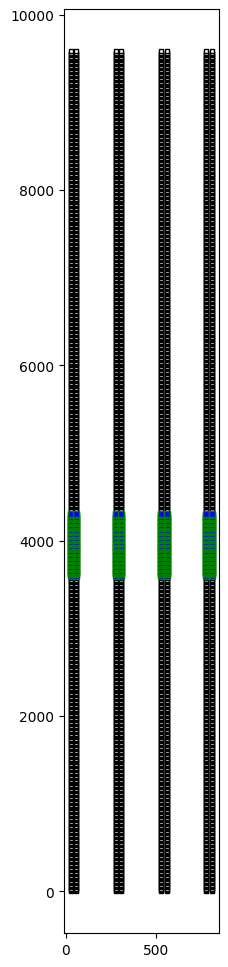

Saving probe file to: D:\SortingTemp\24-05-31_DH23_A1-IC_g0\24-05-31_DH23_A1-IC_g0_imec1\probe.json
Running CatGT...

Interpreting binary file as default dtype='int16'. If data was saved in a different format, specify `data_dtype`.
Using GPU for PyTorch computations. Specify `device` to change this.
Preprocessing filters computed in  182.71s; total  182.72s

computing drift
Re-computing universal templates from data.


 14%|█▎        | 1852/13507 [4:27:30<27:33:57,  8.51s/it]

In [4]:
# set your data directory here, should contain the .ap.bin and .ap.meta files
file_dir = Path("D:\\SortingTemp\\24-05-31_DH23_A1-IC_g0\\24-05-31_DH23_A1-IC_g0_imec1")

# skip CatGT if already ran
skip_catgt = True

# useful Kilosort settings
config = {'tmin': 0, # start time in seconds
          'tmax': np.inf, # end time in seconds
          'artifact_threshold': np.inf, # threshold for detecting artifacts
          'batch_size': 60000, # number of samples per batch
          'nblocks': 1, # number of blocks to split the data into for drift correction
          'Th_universal': 9, # threshold for detecting spikes used in universal templates
          'Th_learned': 8} # threshold for detecting spikes used in learned templates

# get the data dir
data_dir = file_dir.parents[1]

# get the meta file in the folder
meta_file = str(list(file_dir.glob('*.ap.meta'))[0])

# get the binary file in the folder
bin_file = list(file_dir.glob('*.ap.bin'))
bin_file = [str(x) for x in bin_file if str(x).find('_tcat') == -1][0]

# get the run name
run_name = file_dir.parts[-2]
run_name = re.sub(r'_g\d+$', '', run_name)

# get the gate and trigger numbers
gate_num = re.search(r'_g(\d+)', bin_file).group(1)
trig_num = re.search(r'_t(\d+)', bin_file).group(1)

# get the probe number
probe_num = re.search(r'_imec(\d+)', bin_file).group(1)

# print directory and file names
print('Files directory: {}'.format(file_dir))
print('Meta file: {}'.format(meta_file))
print('Binary file: {}'.format(bin_file))
print('Data directory: {}'.format(data_dir))
print('Run name: {}'.format(run_name))
print('Gate number: {}'.format(gate_num))
print('Trigger number: {}'.format(trig_num))
print('Probe number: {}'.format(probe_num))

# get the coordinates of the electrodes from the meta file
xc, yc, shanks, kcoords, n_chan = sglx.MetaToCoords(Path(meta_file), outType=0, showPlot=True)
shank_sep = 250
xc = xc + shanks*shank_sep
n_chan = int(n_chan)
chan_map = np.arange(n_chan-1) # exclude last channel which is sync

probe =  {'chanMap': chan_map, 'xc': xc, 'yc': yc, 'kcoords': kcoords, 'n_chan': n_chan}

probe_file = os.path.join(str(file_dir), 'probe.json')
print('Saving probe file to: {}'.format(probe_file))

save_probe(probe, probe_file)

# test if already ran CatGT
tcat_file = bin_file.replace('_t'+trig_num, '_tcat')

if skip_catgt and Path(tcat_file).exists():
    print('CatGT already ran, skipping...')
else:
    print('Running CatGT...')
    # file and directory names for CatGT
    catgt_files = '-dir={} -run={} -g={} -t={} -prb={}'.format(
        data_dir, run_name, gate_num, trig_num, probe_num)

    # options for CatGT, can be edited as needed
    catgt_opts = '-ap -prb_fld -gbldmx' # -apfilter=butter,2,300,9000, dropped filter

    # full command for CatGT
    catgt_cmd = 'CatGT {} {}'.format(catgt_files, catgt_opts)

    # run catGT
    cmd_out = subprocess.run(catgt_cmd, shell=True, capture_output=True)
    print(cmd_out.stdout.decode('utf-8'))

# initialize settings with default values
settings = DEFAULT_SETTINGS

# update settings with custom values from config
for key, value in config.items():
    settings[key] = value

# run Kilosort
ops, st, clu, tf, Wall, similar_templates, is_ref, est_contam_rate, kept_spikes \
    = run_kilosort(settings, probe=probe, filename=tcat_file, data_dir=file_dir)